### ISSUES and TODOs

- see `README.md`

1) use one-sided spectrum

2) sometimes FD after augmentation is just a flat line. Why?

3) is it VALID to zero out frequency coefficients for augmentation?

In [39]:
import os, argparse, json, copy

from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.fft as fft

import pandas as pd
import numpy as np
from termcolor import cprint
from pprint import pprint
from tqdm import tqdm
from datetime import datetime


from trainer import Trainer, model_finetune, model_test, model_pretrain
from augmentations import *
from dataloader import MIdatasetMC
from sklearn.utils.class_weight import compute_class_weight
from config_files.BIG_EEG_MI import Config as Configs
from utils import _logger, set_requires_grad
from model import *
from utils import _calc_metrics, copy_Files
from loss import * # base_Model, base_Model_F, target_classifier


from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    average_precision_score,
    accuracy_score,
    precision_score,
    f1_score,
    recall_score,
)

# For Arial
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams["text.usetex"] = False

# for latex:
# matplotlib.rcParams['font.family'] = "DejaVu Sans"
# matplotlib.rcParams['font.serif'] = "Computer Modern"
# matplotlib.rcParams["text.usetex"] = True

matplotlib.rcParams["lines.linewidth"] = 3
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["axes.labelsize"] = 22
matplotlib.rcParams["xtick.labelsize"] = 22
matplotlib.rcParams["ytick.labelsize"] = 22
matplotlib.rcParams["font.size"] = 22
matplotlib.rcParams["legend.fontsize"] = 22
matplotlib.rcParams["axes.titlesize"] = 22
matplotlib.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams["figure.autolayout"] = True

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False


print(f'CUDA available: {torch.cuda.is_available()}')

device_count = torch.cuda.device_count()
for i in range(device_count):
    torch.cuda.set_device(i)
    cur_device_id = torch.cuda.current_device()
    cur_device_name = torch.cuda.get_device_name(cur_device_id)
    print(f'Current device:\nID {cur_device_id} | Name: {cur_device_name}')
    print(f'supported arch list: {torch.cuda.get_arch_list()}\n')
    
def get_loss_wts(a, b):
    w0 = b.abs().item()/(a.abs().item() + b.abs().item())
    w1 = a.abs().item()/(a.abs().item() + b.abs().item())
    return w0, w1

CUDA available: True
Current device:
ID 0 | Name: RTX A6000
supported arch list: ['sm_37', 'sm_50', 'sm_60', 'sm_70']

Current device:
ID 1 | Name: Quadro P2200
supported arch list: ['sm_37', 'sm_50', 'sm_60', 'sm_70']



In [2]:
2+2

4

In [3]:
training_mode = 'pre_train'   # 'fine_tune_test'
device = 'cuda:1'
configs = Configs()
configs.report()


{'CNNoutput_channel': 10,
 'Context_Cont': <config_files.BIG_EEG_MI.Context_Cont_configs object at 0x7f6124035d30>,
 'TC': <config_files.BIG_EEG_MI.TC object at 0x7f6124035dc0>,
 'TSlength_aligned': 150,
 'augmentation': <config_files.BIG_EEG_MI.augmentations object at 0x7f6124035d00>,
 'batch_size': 64,
 'beta1': 0.9,
 'beta2': 0.99,
 'drop_last': True,
 'dropout': 0.35,
 'features_len': 150,
 'features_len_f': 150,
 'final_out_channels': 128,
 'increased_dim': 1,
 'input_channels': 7,
 'kernel_size': 25,
 'lr': 0.0003,
 'lr_f': 0.0003,
 'num_classes': 2,
 'num_classes_target': 2,
 'num_epoch': 40,
 'optimizer': 'adam',
 'report': <bound method Config.report of <config_files.BIG_EEG_MI.Config object at 0x7f6114fbc8b0>>,
 'stride': 3,
 'target_batch_size': 60}

{'boostFreqBy': 0.1,
 'max_seg': 12,
 'noise_std': 0.3,
 'pertubFreqRatio': 0.1,
 'remove_how_much': 0.1,
 'scaling_mean': 2.0,
 'scaling_sigma': 0.1,
 'superposition': False}


In [4]:
# load the data and instantiate the Dataset class

path = '/home/roman/CODE/tachikoma-analysis/DATA'

# load the torch tensor
dataset = torch.load(os.path.join(path, "BIG_MI_11_datasets_36089samp.pt"))

<AxesSubplot:ylabel='ds'>

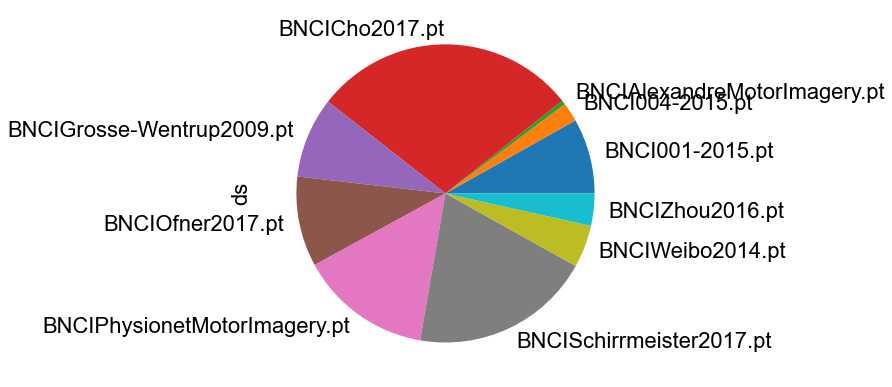

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
dataset['meta'].groupby('ds').ds.count().plot.pie(ax=ax)

In [6]:
# set aside one dataset for finetuning, the rest are for pre-training and testing

pretrain_idx = np.where(dataset['meta'].ds != 'BNCIPhysionetMotorImagery.pt')[0]
finetune_idx_ = np.where(dataset['meta'].ds == 'BNCIPhysionetMotorImagery.pt')[0]

pretrain_dataset = dict()
finetune_dataset_ = dict()
finetune_dataset = dict()
test_dataset = dict()


pretrain_dataset['samples'] = copy.deepcopy(dataset['samples'][pretrain_idx, :, :])
pretrain_dataset['labels'] = copy.deepcopy(dataset['labels'][pretrain_idx])
pretrain_dataset['meta'] = copy.deepcopy(dataset['meta'].iloc[pretrain_idx].reset_index(drop=True))

finetune_dataset_['samples'] = copy.deepcopy(dataset['samples'][finetune_idx_, :, :])
finetune_dataset_['labels'] = copy.deepcopy(dataset['labels'][finetune_idx_])
finetune_dataset_['meta'] = copy.deepcopy(dataset['meta'].iloc[finetune_idx_].reset_index(drop=True))


finetune_idx, test_idx = train_test_split(list(range(finetune_dataset_['meta'].shape[0])), test_size=0.2)

finetune_dataset['samples'] = copy.deepcopy(finetune_dataset_['samples'][finetune_idx, :, :])
finetune_dataset['labels'] = copy.deepcopy(finetune_dataset_['labels'][finetune_idx])
finetune_dataset['meta'] = copy.deepcopy(finetune_dataset_['meta'].iloc[finetune_idx].reset_index(drop=True))

test_dataset['samples'] = copy.deepcopy(finetune_dataset_['samples'][test_idx, :, :])
test_dataset['labels'] = copy.deepcopy(finetune_dataset_['labels'][test_idx])
test_dataset['meta'] = copy.deepcopy(finetune_dataset_['meta'].iloc[test_idx].reset_index(drop=True))

del finetune_dataset_
del dataset

In [7]:
pretrain_dataset['meta']

,subject,session,run,label,labs,ds
0,1,imagination,run_0,right_pronation,0,BNCIOfner2017.pt
1,1,imagination,run_0,right_hand_close,0,BNCIOfner2017.pt
2,1,imagination,run_0,right_hand_open,0,BNCIOfner2017.pt
3,1,imagination,run_0,right_supination,0,BNCIOfner2017.pt
4,1,imagination,run_0,right_hand_open,0,BNCIOfner2017.pt
...,...,...,...,...,...,...
29426,8,session_0,run_0,right_hand,0,BNCIAlexandreMotorImagery.pt
29427,8,session_0,run_0,right_hand,0,BNCIAlexandreMotorImagery.pt
29428,8,session_0,run_0,right_hand,0,BNCIAlexandreMotorImagery.pt
29429,8,session_0,run_0,right_hand,0,BNCIAlexandreMotorImagery.pt


In [8]:
finetune_dataset['meta']

,subject,session,run,label,labs,ds
0,94,session_0,run_2,left_hand,1,BNCIPhysionetMotorImagery.pt
1,41,session_0,run_0,left_hand,1,BNCIPhysionetMotorImagery.pt
2,14,session_0,run_0,left_hand,1,BNCIPhysionetMotorImagery.pt
3,20,session_0,run_0,left_hand,1,BNCIPhysionetMotorImagery.pt
4,84,session_0,run_2,left_hand,1,BNCIPhysionetMotorImagery.pt
...,...,...,...,...,...,...
3929,94,session_0,run_1,right_hand,0,BNCIPhysionetMotorImagery.pt
3930,71,session_0,run_1,right_hand,0,BNCIPhysionetMotorImagery.pt
3931,86,session_0,run_1,right_hand,0,BNCIPhysionetMotorImagery.pt
3932,91,session_0,run_0,right_hand,0,BNCIPhysionetMotorImagery.pt


In [9]:
test_dataset['meta']

,subject,session,run,label,labs,ds
0,1,session_0,run_1,right_hand,0,BNCIPhysionetMotorImagery.pt
1,6,session_0,run_0,left_hand,1,BNCIPhysionetMotorImagery.pt
2,12,session_0,run_1,right_hand,0,BNCIPhysionetMotorImagery.pt
3,12,session_0,run_2,left_hand,1,BNCIPhysionetMotorImagery.pt
4,5,session_0,run_0,right_hand,0,BNCIPhysionetMotorImagery.pt
...,...,...,...,...,...,...
979,108,session_0,run_2,left_hand,1,BNCIPhysionetMotorImagery.pt
980,99,session_0,run_2,left_hand,1,BNCIPhysionetMotorImagery.pt
981,44,session_0,run_1,left_hand,1,BNCIPhysionetMotorImagery.pt
982,104,session_0,run_1,left_hand,1,BNCIPhysionetMotorImagery.pt


In [10]:
# seed everything
SEED = 0
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [11]:
# instantiate the Dataset class
ds = MIdatasetMC(pretrain_dataset, configs)

torch.Size([29431, 7, 150])


Text(0.5, 0.98, 'Sample ID: 12002')

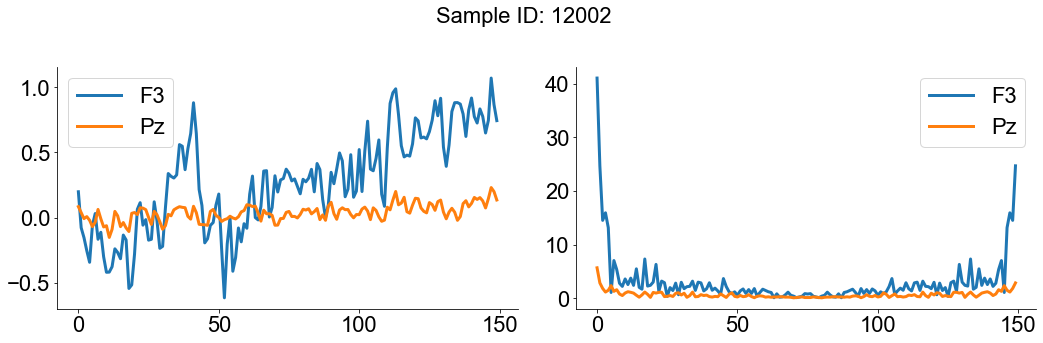

In [94]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))

sampid = np.random.choice(len(ds))
sampid = 12002

choi = ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']


x,_,_,_,_,_,_,_ = ds[sampid]
x_f = fft.fft(x).abs()

ax0.plot(x[choi.index('F3'),:].squeeze().numpy(), label=f'{choi[0]}')
ax0.plot(x[choi.index('F4'),:].squeeze().numpy(), label=f'{choi[-1]}')
ax0.legend()

ax1.plot(x_f[choi.index('F3'),:].squeeze().numpy(), label=f'{choi[0]}')
ax1.plot(x_f[choi.index('F4'),:].squeeze().numpy(), label=f'{choi[-1]}')
ax1.legend()

plt.suptitle(f'Sample ID: {sampid}', fontsize=22)

In [96]:
# metadata per each data point (for debugging)

finetune_dataset['meta']

,subject,session,run,label,labs,ds
0,14,session_0,run_1,right_hand,0,BNCIPhysionetMotorImagery.pt
1,92,session_0,run_2,left_hand,1,BNCIPhysionetMotorImagery.pt
2,83,session_0,run_2,right_hand,0,BNCIPhysionetMotorImagery.pt
3,35,session_0,run_0,left_hand,1,BNCIPhysionetMotorImagery.pt
4,64,session_0,run_0,right_hand,0,BNCIPhysionetMotorImagery.pt
...,...,...,...,...,...,...
3929,108,session_0,run_2,left_hand,1,BNCIPhysionetMotorImagery.pt
3930,73,session_0,run_1,left_hand,1,BNCIPhysionetMotorImagery.pt
3931,37,session_0,run_2,left_hand,1,BNCIPhysionetMotorImagery.pt
3932,58,session_0,run_2,right_hand,0,BNCIPhysionetMotorImagery.pt


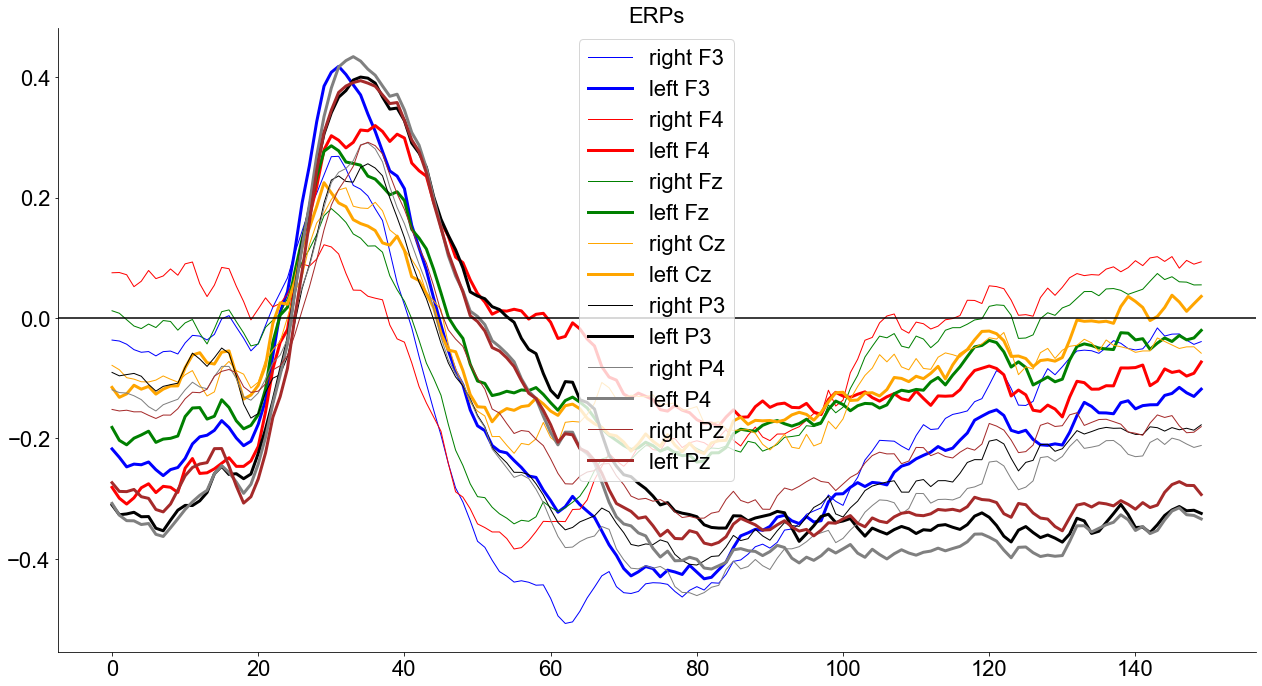

In [97]:
c = ['blue', 'red', 'green', 'orange', 'black', 'grey', 'brown']

plt.figure(figsize=(18, 10))

rights = np.where(finetune_dataset['meta'].labs == 0)[0]
lefts =  np.where(finetune_dataset['meta'].labs == 1)[0]

for i in range(7):
    plt.plot(finetune_dataset['samples'][rights, i,: ].mean(axis=0).squeeze(), color=c[i], lw=1, label=f'right {choi[i]}')
    plt.plot(finetune_dataset['samples'][lefts,  i,: ].mean(axis=0).squeeze(), color=c[i], lw=3, label=f'left {choi[i]}')
    
plt.legend()
plt.axhline(0, color='k', lw=1.5)

_ = plt.title('ERPs')

In [98]:
# get one data point (not batch)

x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta = ds[1000]
meta, y

({'subject': 5,
  'session': 'imagination',
  'run': 'run_1',
  'label': 'right_supination',
  'labs': 0,
  'ds': 'BNCIOfner2017.pt'},
 tensor(0))

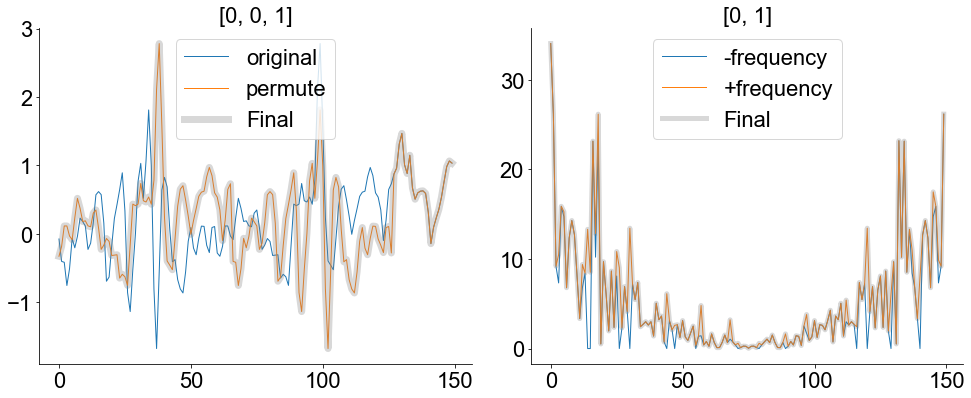

In [99]:
# validate augmentations (debugging)

ch = 4

x_t, _, _, x_f, _, _, _,_ = ds[2]
aug_T, aug_1_t, aug_2_t, aug_3_t, msk_t = DataTransform_TD(x_t, configs)
aug_F, aug_1_f, aug_2_f, msk_f = DataTransform_FD(x_f, configs)

n = np.random.choice(x_t.shape[0])


fig, (ax, ax1) = plt.subplots(1,2,figsize=(14,6))

if len(x_t.shape) == 2:
    ax.plot(x_t[ch,:].detach().numpy(), lw=1, label='original')
    if np.argmax(msk_t.tolist()) == 0:
        ax.plot(aug_1_t[ch,:].detach().numpy(), lw=1, label='jitter')
    elif np.argmax(msk_t.tolist()) == 1:
        ax.plot(aug_2_t[ch,:].detach().numpy(), lw=1, label='scale')
    elif np.argmax(msk_t.tolist()) == 2:
        ax.plot(aug_3_t[ch,:].detach().numpy(), lw=1, label='permute')
    else:
        raise
    ax.plot(aug_T[ch,:].detach().numpy(), lw=7, alpha=0.3, color='grey', label='Final')
    ax.set_title(msk_t.tolist())
    ax.legend()


    ax1.plot(aug_1_f[ch,:].detach().numpy(), lw=1, label='-frequency')
    ax1.plot(aug_2_f[ch,:].detach().numpy(), lw=1, label='+frequency')
    ax1.plot(aug_F[ch,:].detach().numpy(), lw=5, alpha=0.3, color='grey', label='Final')
    ax1.set_title(msk_f.tolist())
    ax1.legend()
    # ax1.set_ylim(0, 20)
    # ax1.set_xlim(150, 250)
    
if len(x_t.shape) == 3:
    ax.plot(x_t[n, ch,:].detach().numpy(), lw=1, label='original')
    ax.plot(aug_1_t[n, ch,:].detach().numpy(), lw=1, label='jitter')
    ax.plot(aug_2_t[n, ch,:].detach().numpy(), lw=1, label='scale')
    ax.plot(aug_3_t[n, ch,:].detach().numpy(), lw=1, label='permute')
    ax.plot(aug_T[n, ch,:].detach().numpy(), lw=7, alpha=0.3, color='grey', label='Final')
    ax.set_title(msk_t[n,:].tolist())
    ax.legend()


    ax1.plot(aug_1_f[n, ch,:].detach().numpy(), lw=1, label='-frequency')
    ax1.plot(aug_2_f[n, ch,:].detach().numpy(), lw=1, label='+frequency')
    ax1.plot(aug_F[n, ch,:].detach().numpy(), lw=5, alpha=0.3, color='grey', label='Final')
    ax1.set_title(msk_f[n,:].tolist())
    ax1.legend()
    # ax1.set_ylim(0, 20)
#     ax1.set_xlim(150, 250)


In [100]:
# create a dataloader with the optimal number of workers

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

train_dl = torch.utils.data.DataLoader(
    dataset=ds,
    batch_size=configs.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=14) # optimal: 14 workers with batch_size=60

In [17]:
%%time
for x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta in tqdm(train_dl):
    pass

x_t.shape, y.shape, x_t_aug.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 536/536 [00:03<00:00, 163.58it/s]

CPU times: user 1.73 s, sys: 696 ms, total: 2.43 s
Wall time: 3.28 s


(torch.Size([64, 7, 150]), torch.Size([64]), torch.Size([64, 7, 150]))

In [18]:
# for debugging, inspect where each data point comes from

pd.DataFrame(meta).head(10)

,subject,session,run,label,labs,ds
0,2,session_0,run_0,right_hand,0,BNCIAlexandreMotorImagery.pt
1,4,session_A,run_0,right_hand,0,BNCI001-2015.pt
2,96,session_0,run_2,left_hand,1,BNCIPhysionetMotorImagery.pt
3,91,session_0,run_1,right_hand,0,BNCIPhysionetMotorImagery.pt
4,10,session_0,train,left_hand,1,BNCISchirrmeister2017.pt
5,10,session_B,run_0,right_hand,0,BNCI001-2015.pt
6,13,imagination,run_7,right_hand_open,0,BNCIOfner2017.pt
7,8,imagination,run_0,right_hand_open,0,BNCIOfner2017.pt
8,14,session_0,test,left_hand,1,BNCISchirrmeister2017.pt
9,2,session_0,run_1,right_hand,0,BNCIZhou2016.pt


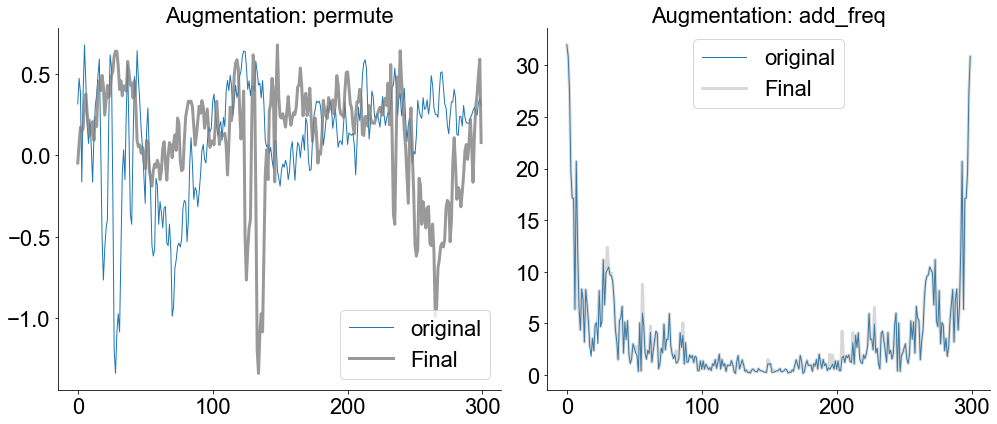

In [13]:
# inspect data augmented points

n = 13
ch = 0

TDaugNames = ['jitter', 'scale', 'permute']
FDaugNames = ['rm_freq', 'add_freq']

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(14,6))

ax.plot(x_t[n, ch,:].detach().numpy(), lw=1, label='original')
ax.plot(x_t_aug[n, ch,:].detach().numpy(), lw=3, alpha=0.8, color='grey', label='Final')
ax.set_title(f'Augmentation: {TDaugNames[np.argmax(msk_t[n].tolist())]}')
ax.legend()
ax1.plot(x_f[n, ch,:].detach().numpy(), lw=1, label='original')
ax1.plot(x_f_aug[n, ch,:].detach().numpy(), lw=3, alpha=0.3, color='grey', label='Final')
ax1.set_title(f'Augmentation: {FDaugNames[np.argmax(msk_f[n].tolist())]}')
ax1.legend()
# ax1.set_ylim(0, 20)
# ax1.set_xlim(150, 250)

In [102]:
# Build Model 
"""Here are two models, one basemodel, another is temporal contrastive model"""

TFC_model = TFC_new(configs).to(device)
classifier = target_classifier(configs).to(device)

cprint(TFC_model, color='grey')

cprint(classifier, color='red')

TFC_new(
  (conv_block1_t): Sequential(
    (0): Conv1d(7, 32, kernel_size=(25,), stride=(3,), padding=(12,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.35, inplace=False)
  )
  (conv_block2_t): Sequential(
    (0): Conv1d(32, 64, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_block3_t): Sequential(
    (0): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (projector_t): Sequential(
    

In [103]:
# load model parameters
# TFC_model.load_state_dict(torch.load('TFC_model.wts'))

In [104]:
model_optimizer = torch.optim.Adam(TFC_model.parameters(), lr=configs.lr, betas=(configs.beta1, configs.beta2), weight_decay=3e-4)
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=configs.lr, betas=(configs.beta1, configs.beta2), weight_decay=3e-4)


In [105]:
# get number of parameters
a = 0
for p in TFC_model.parameters():
    a += p.flatten().shape[0]
print(f'number of parameters in model: {a}')
    
a = 0
classifier = target_classifier(configs).to(device)
for p in classifier.parameters():
    a += p.flatten().shape[0]
print(f'number of parameters in classifier: {a}')

number of parameters in model: 767552
number of parameters in classifier: 16578


In [109]:
ep

18

In [110]:
# pretrain:

# instantiate the Dataset class
pretrain_ds = MIdatasetMC(pretrain_dataset, configs)

# instantiate a dataloader for the fine-tuning dataset
finetune_dl = torch.utils.data.DataLoader(
    dataset=pretrain_ds,
    batch_size=configs.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=14) # optimal: 14 workers with batch_size=60

TFC_model.train()
model_optimizer = torch.optim.Adam(TFC_model.parameters(),
                                   lr=configs.lr,
                                   betas=(configs.beta1, configs.beta2),
                                   weight_decay=3e-4)

nt_xent_criterion = NTXentLoss_poly(
            device,
            configs.batch_size,
            configs.Context_Cont.temperature,
            configs.Context_Cont.use_cosine_similarity)  # device, 128, 0.2, True

EPOCHS = 40
L, total_loss = [], []

for ep in range(EPOCHS):
    for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in tqdm(enumerate(train_dl)):

        x_t, y = x_t.float().to(device), y.long().to(device)
        x_t_aug = x_t_aug.float().to(device)
        x_f, x_f_aug = x_f.float().to(device), x_f_aug.float().to(device)
        
        model_optimizer.zero_grad()

        # embed time representation and frequency representations (h). Z's are projections into joint TF space
        h_t, z_t, h_f, z_f = TFC_model(x_t, x_f)                 # original data
        h_t_aug, z_t_aug, h_f_aug, z_f_aug = TFC_model(x_t_aug, x_f_aug) # augmented data


        
        loss_t = nt_xent_criterion(h_t, h_t_aug) # original and perturbed data should be close in TD embedding space
        loss_f = nt_xent_criterion(h_f, h_f_aug) # original and perturbed data should be close in FD embedding space

        # time and frequency embeddings should be similar when projected to the joint TF space
        l_TF, l_1, l_2, l_3 = (
            nt_xent_criterion(z_t, z_f),
            nt_xent_criterion(z_t, z_f_aug),
            nt_xent_criterion(z_t_aug, z_f),
            nt_xent_criterion(z_t_aug, z_f_aug))
        
        # Each of the 3 terms below optimize the model towards a smaller l_TF and relatively larger l_(1,2,3)
        loss_c = (1 + l_TF - l_1) + (1 + l_TF - l_2) + (1 + l_TF - l_3) 

        lam = 0.2
        loss = lam * (loss_t + loss_f) + (1 - lam) * loss_c

        total_loss.append(loss.item())

        L.append({'ep': ep,
                  'it': i,
                  'temporal contr. loss': loss_t.item(),
                  'frequency contr. loss': loss_f.item(),
                  'TF consistency loss': l_TF.item(),
                  'TFaug consistency loss': l_1.item(),
                  'TaugF consistency loss': l_2.item(),
                  'TaugFaug consistency loss': l_3.item()})
        loss.backward()
        model_optimizer.step()

459it [00:36, 12.60it/s]
459it [00:36, 12.59it/s]
459it [00:36, 12.55it/s]
459it [00:36, 12.54it/s]
459it [00:36, 12.50it/s]
459it [00:36, 12.70it/s]
459it [00:36, 12.43it/s]
459it [00:36, 12.47it/s]
459it [00:36, 12.49it/s]
459it [00:36, 12.48it/s]
459it [00:36, 12.51it/s]
459it [00:36, 12.47it/s]
459it [00:36, 12.49it/s]
459it [00:36, 12.50it/s]
459it [00:36, 12.54it/s]
459it [00:36, 12.53it/s]
459it [00:36, 12.53it/s]
459it [00:36, 12.56it/s]
459it [00:36, 12.50it/s]
459it [00:36, 12.48it/s]
459it [00:36, 12.47it/s]
459it [00:36, 12.52it/s]
459it [00:36, 12.70it/s]
459it [00:36, 12.49it/s]
459it [00:36, 12.49it/s]
459it [00:36, 12.49it/s]
459it [00:36, 12.51it/s]
459it [00:36, 12.50it/s]
250it [00:20, 12.48it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3c3337d790>
Traceback (most recent call last):
  File "/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_wo

KeyboardInterrupt: 

In [113]:
# # save model parameters

torch.save(TFC_model.state_dict(), 'TFC_model_7ch_pretrained.wts')

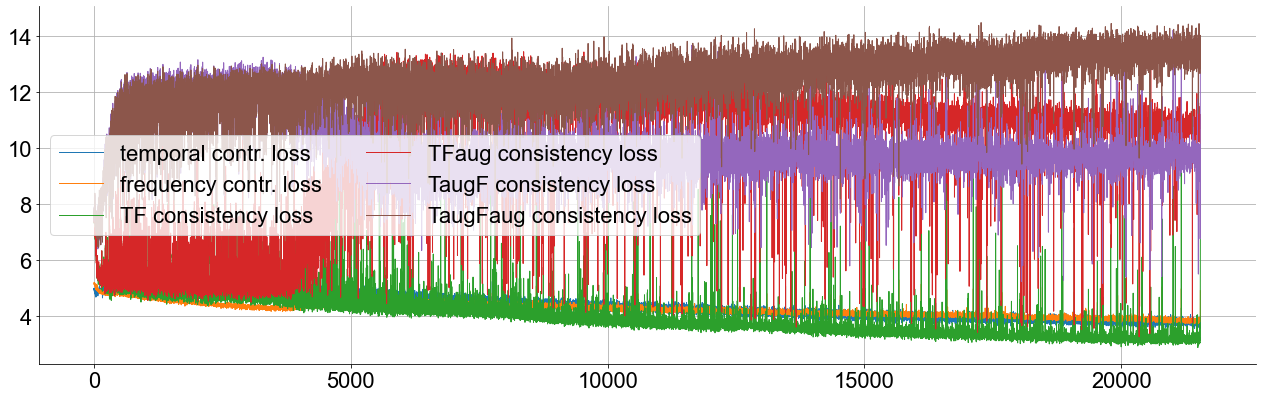

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
pd.DataFrame(L).plot(y=['temporal contr. loss',
                        'frequency contr. loss',
                        'TF consistency loss',
                        'TFaug consistency loss',
                        'TaugF consistency loss',
                        'TaugFaug consistency loss'],
                     ax=ax, lw=1,
                     legend=None)
ax.legend(ncol=2)
ax.grid()

In [44]:
# now fine-tune

# instantiate the Dataset class
finetune_ds = MIdatasetMC(finetune_dataset, configs)

# instantiate a dataloader for the fine-tuning dataset
finetune_dl = torch.utils.data.DataLoader(
    dataset=finetune_ds,
    batch_size=configs.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=14) # optimal: 14 workers with batch_size=60


y = finetune_dataset['labels'].tolist()
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
for i, j in zip(np.unique(y), class_weights):
    print(f'\nClass {i} weight: {j.item():.2f}')

    
# build models from scratch
TFC_model = TFC_new(configs).to(device)
classifier = target_classifier(configs).to(device)

# load pre-trained into the contrastive feature detector model, but not the classifier
TFC_model.load_state_dict(torch.load('TFC_model_7ch_pretrained.wts'))


model_optimizer = torch.optim.Adam(TFC_model.parameters(),
                                   lr=configs.lr,
                                   betas=(configs.beta1, configs.beta2),
                                   weight_decay=3e-4)

classifier_optimizer = torch.optim.Adam(classifier.parameters(),
                                        lr=configs.lr,
                                        betas=(configs.beta1, configs.beta2),
                                        weight_decay=3e-4)

# See explanation in TFC_7ch_Sandbox.ipynb

nt_xent_criterion = NTXentLoss_poly(
            device,
            configs.batch_size,
            configs.Context_Cont.temperature,
            configs.Context_Cont.use_cosine_similarity)  # device, 128, 0.2, True

# reduction?
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')

torch.Size([3934, 7, 150])

Class 0 weight: 1.01

Class 1 weight: 0.99


In [45]:
TFC_model.train()
classifier.train() 

dat = []
# do one epoch of fine-tuning
EPOCHS = 50

for ep in range(EPOCHS):
    pbar = tqdm(enumerate(finetune_dl))
    for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in pbar:

        x_t, y = x_t.float().to(device), y.long().to(device)
        x_t_aug = x_t_aug.float().to(device)
        x_f, x_f_aug = x_f.float().to(device), x_f_aug.float().to(device)

        model_optimizer.zero_grad()
        classifier_optimizer.zero_grad()

        # embed time representation and frequency representations (h). Z's are projections into joint TF space
        h_t, z_t, h_f, z_f = TFC_model(x_t, x_f)                 # original data
        h_t_aug, z_t_aug, h_f_aug, z_f_aug = TFC_model(x_t_aug, x_f_aug) # augmented data

        # contrastive time loss (encourages learning representations that are invariant to noise, translations and amplification)
        # contrastive frequency loss (encourages learning representations that are invariant to spectrum perturbations)
        loss_t = nt_xent_criterion(h_t, h_t_aug) # original and perturbed data should be close in TD embedding space
        loss_f = nt_xent_criterion(h_f, h_f_aug) # original and perturbed data should be close in FD embedding space

        # time and frequency embeddings should be similar when projected to the joint TF space
        l_TF, l_1, l_2, l_3 = (
            nt_xent_criterion(z_t, z_f),
            nt_xent_criterion(z_t, z_f_aug),
            nt_xent_criterion(z_t_aug, z_f),
            nt_xent_criterion(z_t_aug, z_f_aug))

        # Each of the 3 terms below optimize the model towards a smaller l_TF and relatively larger l_(1,2,3)
        # similar to triplet loss, l_TF should be smaller than l_{1,2,3}.
        # time-frequency consistency loss. same samples should be close in TF space, but augmented samples should not be so close to augmented/not augmented
        loss_c = (1 + l_TF - l_1) + (1 + l_TF - l_2) + (1 + l_TF - l_3) 

        # classifier
        fea_concat = torch.cat((z_t, z_f), dim=1)
        predictions = classifier(fea_concat)  # how to define classifier? MLP? CNN?
        fea_concat_flat = fea_concat.reshape(fea_concat.shape[0], -1)
        loss_class = criterion(predictions, y)  # predictor loss, actually, here is training loss
        
        lam = 0.2     
        feature_loss = (1 - lam) * loss_c + lam * (loss_t + loss_f)
        
        w0, w1 = get_loss_wts(loss_class, feature_loss)
        loss = w0 * loss_class + w1 * feature_loss
        pbar.set_description(f'L0: {loss_class:.2f} w0: {w0:.2f} L1: {feature_loss:.2f} w1: {w1:.2f}')


        acc_bs = y.eq(predictions.detach().argmax(dim=1)).float().mean()
        onehot_label = F.one_hot(y, num_classes=2)
        pred_numpy = predictions.detach().cpu().numpy()

        auc_bs = roc_auc_score(
            onehot_label.detach().cpu().numpy(),
            pred_numpy,
            average="macro",
            multi_class="ovr")

        prc_bs = average_precision_score(
            onehot_label.detach().cpu().numpy(),
            pred_numpy)            


        labels_numpy = y.detach().cpu().numpy()
        pred_numpy = np.argmax(pred_numpy, axis=1)

        precision = precision_score(labels_numpy, pred_numpy, average="macro", zero_division=0)
        recall = recall_score(labels_numpy, pred_numpy, average="macro", zero_division=0)
        F1 = f1_score(labels_numpy, pred_numpy, average="macro", zero_division=0)

        dat.append({'ep': ep,
                    'temporal contrastive loss': loss_t.item(),
                    'frequency contrastive loss': loss_f.item(),
                    'time-frequency (t-f) consistency': l_TF.item(),
                    'time - aug. freq (t-~f) consistency': l_1.item(),
                    'aug.time - freq (~t-f) consistency': l_2.item(),
                    'aug.time - aug. freq (~t-~f) consistency': l_3.item(),
                    'classifier loss': loss_class.item(),
                    'total_loss': loss.item(),
                    'classifier accuracy': acc_bs.item(),
                    'AUC': auc_bs,
                    'PRC': prc_bs,
                    'recall': recall,
                    'precision': precision,
                    'F1-score': F1})

        loss.backward()
        model_optimizer.step()
        classifier_optimizer.step()
dat = pd.DataFrame(dat)

L0: 0.69 w0: 0.95 L1: -12.70 w1: 0.05: : 61it [00:05, 11.71it/s]
L0: 0.70 w0: 0.95 L1: -14.66 w1: 0.05: : 61it [00:05, 11.56it/s]
L0: 0.69 w0: 0.95 L1: -14.28 w1: 0.05: : 61it [00:05, 11.38it/s]
L0: 0.69 w0: 0.96 L1: -15.26 w1: 0.04: : 61it [00:05, 11.36it/s]
L0: 0.70 w0: 0.96 L1: -15.23 w1: 0.04: : 61it [00:05, 11.50it/s]
L0: 0.69 w0: 0.95 L1: -14.57 w1: 0.05: : 61it [00:05, 11.49it/s]
L0: 0.68 w0: 0.96 L1: -15.02 w1: 0.04: : 61it [00:05, 11.38it/s]
L0: 0.68 w0: 0.96 L1: -15.04 w1: 0.04: : 61it [00:05, 11.42it/s]
L0: 0.69 w0: 0.96 L1: -15.03 w1: 0.04: : 61it [00:05, 11.33it/s]
L0: 0.65 w0: 0.96 L1: -15.50 w1: 0.04: : 61it [00:05, 11.49it/s]
L0: 0.69 w0: 0.96 L1: -14.67 w1: 0.04: : 61it [00:05, 11.48it/s]
L0: 0.66 w0: 0.96 L1: -14.01 w1: 0.04: : 61it [00:05, 11.39it/s]
L0: 0.61 w0: 0.96 L1: -14.13 w1: 0.04: : 61it [00:05, 11.27it/s]
L0: 0.50 w0: 0.96 L1: -12.50 w1: 0.04: : 61it [00:05, 11.33it/s]
L0: 0.52 w0: 0.96 L1: -14.00 w1: 0.04: : 61it [00:05, 11.30it/s]
L0: 0.44 w0: 0.97 L1: -14

In [46]:
# dat = pd.DataFrame(dat)
dat.columns

Index(['ep', 'temporal contrastive loss', 'frequency contrastive loss',
       'time-frequency (t-f) consistency',
       'time - aug. freq (t-~f) consistency',
       'aug.time - freq (~t-f) consistency',
       'aug.time - aug. freq (~t-~f) consistency', 'classifier loss',
       'total_loss', 'classifier accuracy', 'AUC', 'PRC', 'recall',
       'precision', 'F1-score'],
      dtype='object')

<AxesSubplot:>

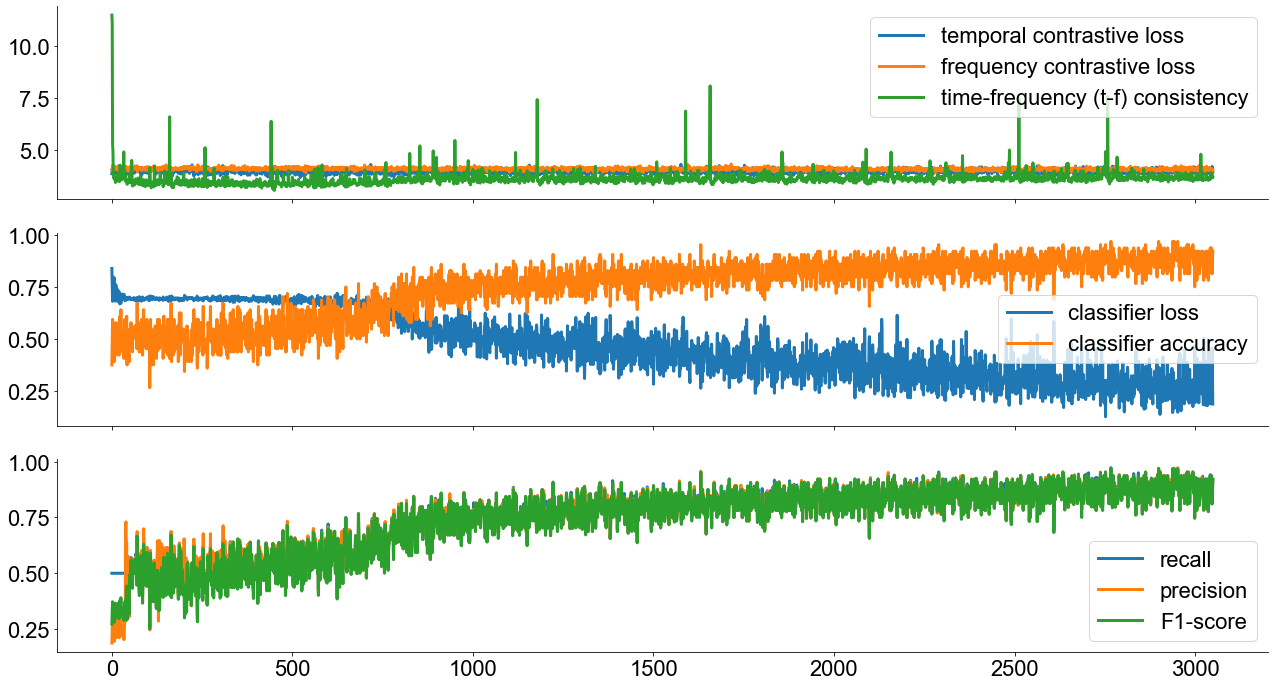

In [49]:
fig, ax = plt.subplots(3, 1, figsize=(18, 10), sharex=True)
dat.plot(y=['temporal contrastive loss',
            'frequency contrastive loss',
            'time-frequency (t-f) consistency'], ax=ax[0])

dat.plot(y=['classifier loss', 'classifier accuracy'], ax=ax[1])

dat.plot(y=['recall', 'precision', 'F1-score'], ax=ax[2])

In [50]:
from einops import rearrange, repeat

In [62]:
xx = rearrange(x_t, 'b c t -> (b c) 1 t')
print(xx.shape)
yy = rearrange(xx,  '(b c) 1 t -> b c t', c=7)
print(yy.shape)

torch.Size([448, 1, 150])
torch.Size([64, 7, 150])


In [63]:
z_t.shape

torch.Size([64, 128])

In [121]:
training_mode = 'fine_tune'


nt_xent_criterion = NTXentLoss_poly(
            device,
            60, # batch size
            configs.Context_Cont.temperature,
            configs.Context_Cont.use_cosine_similarity)  # device, 128, 0.2, True


(total_loss, total_acc, total_auc, total_prc, 
precision, recall, F1, LOSS_P, 
labels_numpy, pred_numpy) = model_finetune(TFC_model,
                                             valid_dl,
                                             nt_xent_criterion,
                                             device,
                                             training_mode,
                                             model_optimizer,
                                             classifier=classifier,
                                             classifier_optimizer=classifier_optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


In [123]:
def test_model(model, classifier, test_dl):
    model.eval()
    classifier.eval()

    total_loss = []
    total_acc = []
    total_auc = []
    total_prc = []   

    for data, labels, aug1, data_f, aug1_f in tqdm(test_dl):
        data, labels = data.float().to(device), labels.long().to(device)
        data_f = data_f.float().to(device)
        aug1 = aug1.float().to(device)
        aug1_f = aug1_f.float().to(device)
            

        # embed time representation and frequency representations (h). Z's are projections into joint TF space
        h_t, z_t, h_f, z_f = model(data, data_f)                 # original data
        h_t_aug, z_t_aug, h_f_aug, z_f_aug = model(aug1, aug1_f) # augmented data


        fea_concat = torch.cat((z_t, z_f), dim=1)
        predictions = classifier(fea_concat)  # how to define classifier? MLP? CNN?
        
        
        acc_bs = labels.eq(predictions.detach().argmax(dim=1)).float().mean()
        onehot_label = F.one_hot(labels) # <<<<<<<<<<<<<<<<<<<<<<<<<<<<< num_ classes !!!!
        pred_numpy = predictions.detach().cpu().numpy()

        auc_bs = roc_auc_score(
            onehot_label.detach().cpu().numpy(),
            pred_numpy,
            average="macro",
            multi_class="ovr")
        prc_bs = average_precision_score(
            onehot_label.detach().cpu().numpy(),
            pred_numpy)

        total_acc.append(acc_bs.item())
        total_auc.append(auc_bs.item())
        total_prc.append(prc_bs.item())
        
        
    labels_numpy = labels.detach().cpu().numpy()
    pred_numpy = np.argmax(pred_numpy, axis=1)
    precision = precision_score(labels_numpy, pred_numpy, average="macro")
    recall = recall_score(labels_numpy, pred_numpy, average="macro")
    F1 = f1_score(labels_numpy, pred_numpy, average="macro")
    return (total_acc, total_auc, total_prc, 
            precision, recall, F1, LOSS_P, 
            labels_numpy, pred_numpy)

In [124]:
(total_acc, total_auc, total_prc, 
            precision, recall, F1, LOSS_P, 
            labels_numpy, pred_numpy) = test_model(TFC_model, classifier, test_dl)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 127.62it/s]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


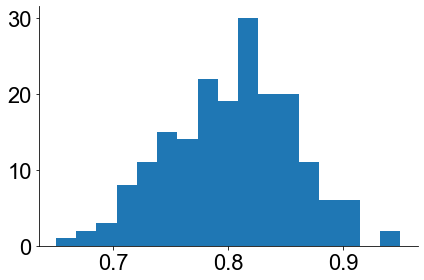

In [125]:
_ = plt.hist(total_acc, bins=17)

In [127]:
for data, labels, aug1, data_f, aug1_f in tqdm(test_dl):
    print(labels)

 15%|██████████████████▏                                                                                                    | 29/190 [00:00<00:01, 140.52it/s]

tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1])
tensor([1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1])
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 

 43%|██████████████████████████████████████████████████▋                                                                    | 81/190 [00:00<00:00, 213.50it/s]

tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1])
tensor([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 

 72%|█████████████████████████████████████████████████████████████████████████████████████                                 | 137/190 [00:00<00:00, 248.94it/s]

tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 204.84it/s]

tensor([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1])
tensor([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1])
tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0])
tensor([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 